# Basic RNN in TensorFlow

This notebook explains how to build a simple recurrent neural network (RNN) in TensorFlow. It does *not* use the TensorFlow RNN API but performs all computations manually (which helps to understand what is happening in an RNN). The code is based on an existing [tutorial](https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767).

In [1]:
% matplotlib inline
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Explanation: truncated Backpropagation

A recurrent neural network is designed in a way such that the output at a certain time step depends on arbitrarily distant inputs. In other words: when building an RNN in TensorFlow, the graph would have to be as wide as the input sequence.
Unfortunately, this makes backpropagation computation both expensive and ineffective because gradients propagated over many time steps tend to either vanish (most of the time) or explode.

A common solution to this problem is to create an "unrolled" version of the recurrent network that contains a fixed number (*truncated_backprop_steps*) of RNN inputs and outputs. In other words: backpropagation is "truncated" such that errors are only backpropagated for a fixed number of steps. A higher number of steps enables capturing long-term dependencies but is also more expensive (both regarding memory and computation).

The model is then trained on this finite approximation of the recurrent network. Accordingly, at each time step the network is fed with inputs of length *truncated_backprop_steps*. The backward pass is performed after each input block. A short explanation is given on TensorFlow's [website](https://www.tensorflow.org/tutorials/recurrent#truncated-backpropagation).

In [2]:
# Global configuration parameters
n_epochs = 20
total_series_length = 50000
truncated_backprop_steps = 15
state_size = 4 
n_classes = 2
echo_step = 3 # Number of steps the input is shifted to the right
batch_size = 5
n_batches = total_series_length//batch_size//truncated_backprop_steps

eta = 0.01 # Learning rate

## Input data
The input data of our recurrent network will be a vector of random numbers in the range (n_classes). For example, when setting "n_classes = 2", the input vector will contain random binary digits, e.g. [0,1,0,0,0,1,1,0,1,...].

The target output is simply the input vector, shifted "echo_steps" to the right.

In [3]:
def generateData():
    """
    Generates training data. The input data is simply a vector of random
    numbers with n_classes classes. The target output is the input shifted 
    by "echo_steps" steps to the right.
    
    Returns:
        x: numpy array of shape (batch_size,-1) filled with random values
        in the range (n_classes)
        
        y: numpy array of shape (batch_size, -1), x shifted "echo_step" to 
        the right
    """

    x = np.array(np.random.choice(n_classes, total_series_length))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))
    y = y.reshape((batch_size, -1))

    return(x, y)

## Network architecture

The basic architecture of a recurrent network looks as follows ([source](http://www.deeplearningbook.org/)). 

![alt text](basic_rnn.png "Title")


As visibile in the figure, the state $h^{(t)}$  of the network depends both on the input $x^{(t)}$ and the previous state $h^{(t-1)}$.
It is computed as follows:

$$ h^{(t)} = \sigma(U x^{(t)} + W h^{(t-1)} + b) $$

with $\sigma$ beign the $\tanh$ in our implementation.


The output is computed as: 

$$ o^{(t)} = V h^{(t)} + c $$
$$ \hat{y}^{(t)} = \text{softmax}(o^{(t)}) $$


In [4]:
# Create placeholders for the input, target output and state of the network
X_placeholder = tf.placeholder(dtype=tf.float32, shape=[batch_size, truncated_backprop_steps])
y_placeholder = tf.placeholder(dtype=tf.int32, shape=[batch_size, truncated_backprop_steps])
init_state = tf.placeholder(tf.float32, [batch_size, state_size])

# Create variables for weights and biases. To save computation, the two
# weight matrices U and W are concatenated such that we have to perform only
# one matrix multiplication when calculating the state of the recurrent network.
U_W_concat = tf.Variable(np.random.randn(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

V = tf.Variable(np.random.randn(state_size, n_classes), dtype=tf.float32)
c = tf.Variable(np.zeros((1,n_classes)), dtype=tf.float32)


# We split the batch data into adjacent time steps by unpacking the columns of
# the input batch into a list. This causes the network to be trained 
# simultaenously on multiple (namely "batch_size") parts of the input time 
# series. We account for this by setting the state of the network ("init_state")
# to have "batch_size" rows.

input_series = tf.unstack(X_placeholder, axis=1)
labels_series = tf.unstack(y_placeholder, axis=1)

## Forward pass

To perform the forward pass we initialize the state of the RNN to init_state and then process all input examples one after the other.
As mentioned before, the input $x^{(t)}$ and state $h^{(t-1)}$ of the network are concatenated such that we have to perform only a single matrix multiplication.

All states are saved in a list.

In [5]:
# Forward pass
current_state = init_state
state_series = []

for i in input_series:
    inp = tf.reshape(i, [batch_size, 1])
    inp_state_concat = tf.concat([inp, current_state],1)
    new_state = tf.tanh(tf.matmul(inp_state_concat,U_W_concat)+b)
    
    state_series.append(new_state)
    current_state = new_state

## Network output and loss function

To compute the output at each time step, we apply the softmax function as explained before.
The loss is given by computing the cross entropy of the logits. The loss is minimized using the Adam Algorithm.

In [6]:
# Softmax output layer, compute output for each state
logits = [tf.matmul(state, V)+c for state in state_series]
predictions = [tf.nn.softmax(logit) for logit in logits]

# Compute loss
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for label, logit in zip(labels_series, logits)]
total_loss = tf.reduce_mean(losses)

# Training step
train_step = tf.train.AdamOptimizer(learning_rate=eta).minimize(total_loss)

## Training

We train the network for the given number of epoch. For each epoch, we generate a new set of training examples that is fed into the network in batches.

In [7]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    training_losses = []
 
    for epoch in range(n_epochs):
        X_gen, y_gen = generateData()
        
        # The initial state of the network is set to zero
        _current_state = np.zeros((batch_size, state_size))
        
        print("")
        print("Epoch: ", epoch)
        
        for batch_number in range(n_batches):
            start_idx = batch_number * truncated_backprop_steps
            end_idx = start_idx + truncated_backprop_steps
            
            batch_x = X_gen[:, start_idx:end_idx]
            batch_y = y_gen[:, start_idx:end_idx]
            
            _total_loss, _train_step, _current_state = sess.run(
            [total_loss, train_step, current_state], 
            feed_dict={
                X_placeholder: batch_x,
                y_placeholder: batch_y,
                init_state: _current_state
            })
            
            training_losses.append(_total_loss)
            
            if batch_number%100 == 0:
                print("Step: ", batch_number, "Loss:", _total_loss)


Epoch:  0
Step:  0 Loss: 0.775403
Step:  100 Loss: 0.130827
Step:  200 Loss: 0.0295
Step:  300 Loss: 0.0125537
Step:  400 Loss: 0.00882366
Step:  500 Loss: 0.00527875
Step:  600 Loss: 0.0054818

Epoch:  1
Step:  0 Loss: 0.153616
Step:  100 Loss: 0.0033395
Step:  200 Loss: 0.00354613
Step:  300 Loss: 0.00210196
Step:  400 Loss: 0.00210092
Step:  500 Loss: 0.00115995
Step:  600 Loss: 0.00131154

Epoch:  2
Step:  0 Loss: 0.21616
Step:  100 Loss: 0.00135301
Step:  200 Loss: 0.00101389
Step:  300 Loss: 0.000772036
Step:  400 Loss: 0.000830224
Step:  500 Loss: 0.000725011
Step:  600 Loss: 0.000577322

Epoch:  3
Step:  0 Loss: 0.315493
Step:  100 Loss: 0.000832329
Step:  200 Loss: 0.000758668
Step:  300 Loss: 0.000685938
Step:  400 Loss: 0.000516648
Step:  500 Loss: 0.000458007
Step:  600 Loss: 0.000375309

Epoch:  4
Step:  0 Loss: 0.177963
Step:  100 Loss: 0.000522719
Step:  200 Loss: 0.000381885
Step:  300 Loss: 0.00033544
Step:  400 Loss: 0.000308462
Step:  500 Loss: 0.000246425
Step:  60

## Visualize the learning progress

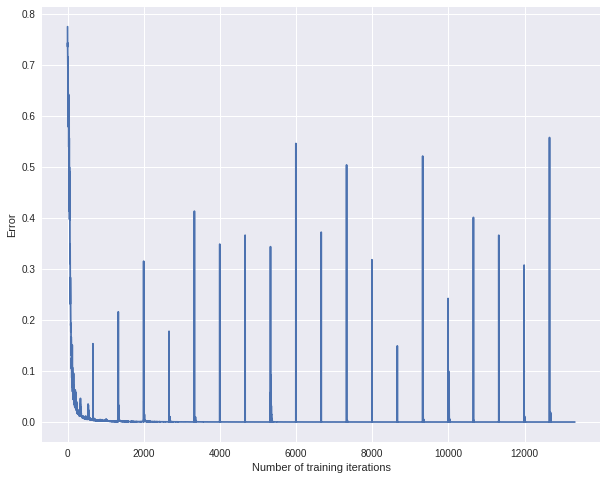

In [8]:
plt.figure(figsize=(10,8));
plt.plot(training_losses);
plt.xlabel('Number of training iterations');
plt.ylabel('Error');